In [1]:
# -*- coding: utf-8 -*-
"""This module defines functions for Dali searching Protein Data Bank."""

import re
import numpy as np
from prody.atomic import Atomic, AtomGroup, AtomMap
from prody.proteins.pdbfile import _getPDBid
from prody.measure import getRMSD, getTransformation
from prody.utilities import checkCoords, checkWeights, createStringIO
from prody import LOGGER, PY3K
from prody import parsePDB, writePDBStream
# if PY3K:
    # import urllib.parse as urllib
    # import urllib.request as urllib2
# else:
    # import urllib
    # import urllib2
from prody.ensemble import Ensemble
from prody.ensemble import PDBEnsemble
import os

__all__ = ['DaliRecord', 'searchDali', 
           'daliFilterMultimer', 'daliFilterMultimers']

def searchDal(pdb, chain=None, subset='fullPDB', daliURL=None, **kwargs):
    """Search Dali server with input of PDB ID (or local PDB file) and chain ID.
    Dali server: http://ekhidna2.biocenter.helsinki.fi/dali/
    
    :arg pdb: PDB code or local PDB file for the protein to be searched

    :arg chain: chain identifier (only one chain can be assigned for PDB)
    :type chain: str

    :arg subset: fullPDB, PDB25, PDB50, PDB90
    :type subset: str
    """
    
    import requests
    
    LOGGER.timeit('_dali')
    # timeout = 120
    timeout = kwargs.pop('timeout', 120)
    
    if daliURL is None:
        daliURL = "http://ekhidna2.biocenter.helsinki.fi/cgi-bin/sans/dump.cgi"
    
    if isinstance(pdb, Atomic):
        atoms = pdb
        chain_set = set(atoms.getChids())
        if chain and not chain in chain_set:
            raise ValueError('input structure (%s) does not have chain %s'%(atoms.getTitle(), chain))
        
        if len(chain_set) > 1:
            if not chain:
                raise TypeError('the structure (%s) contains more than one chain, therefore a chain identifier '
                                'needs to be specified'%pdb.getTitle())
            atoms = atoms.select('chain '+chain)
        else:
            chain = chain_set.pop()
            
        stream = createStringIO()
        writePDBStream(stream, atoms)
        data = stream.getvalue()
        stream.close()
        files = {"file1" : data}

        pdbId = atoms.getTitle()
        pdb_chain = ''
        dali_title = 'Title_'+pdbId+chain
    elif isinstance(pdb, str):
        if os.path.isfile(pdb):
            atoms = parsePDB(pdb)
            chain_set = set(atoms.getChids())
            # pdbId = "s001"
            filename = os.path.basename(pdb)
            filename, ext = os.path.splitext(filename)
            if ext.lower() == '.gz':
                filename2, ext2 = os.path.splitext(filename)
                if ext2.lower() == '.pdb':
                    filename = filename2
            pdbId = filename
            if chain and not chain in chain_set:
                raise ValueError('input PDB file does not have chain ' + chain)
            
            if len(chain_set) > 1:
                if not chain:
                    raise TypeError('PDB file (%s) contains more than one chain, therefore a chain identifier '
                                    'needs to be specified'%pdb)
                atoms = atoms.select('chain '+chain)
                #local_temp_pdb = pdbId+chain+'.pdb'
                #local_temp_pdb = 's001'+chain+'.pdb'
                stream = createStringIO()
                writePDBStream(stream, atoms)
                data = stream.getvalue()
                stream.close()
            else:
                data = open(pdb, "rb")
                chain = chain_set.pop()
            files = {"file1" : data}
            # case: multiple chains.             apply fetch ? multiple times?
            pdb_chain = ''
            dali_title = 'Title_' + pdbId + chain
        else:
            pdbId, ch = _getPDBid(pdb)
            if not chain:
                chain = ch
            if not chain:
                raise TypeError('a chain identifier is needed for the search')
            pdb_chain = pdbId + chain
            dali_title = 'Title_' + pdb_chain
            files = ''
    parameters = { 'cd1' : pdb_chain, 'method': 'search', 'title': dali_title, 'address': '' }
    # enc_params = urllib.urlencode(parameters).encode('utf-8')
    # request = urllib2.Request(daliURL, enc_params)
    request = requests.post(daliURL, parameters, files=files)
    try_error = 3
    while try_error >= 0:
        try:
            # url = urllib2.urlopen(request).url
            url = request.url
            break
        except:
            try_error -= 1
            if try_error >= 0:
                LOGGER.sleep(2, '. Connection error happened. Trying to reconnect...')
                continue
            else:
                # url = urllib2.urlopen(request).url
                url = request.url
                break
    if url.split('.')[-1].lower() in ['html', 'php']:
        # print('test -1: '+url)
        url = url.replace(url.split('/')[-1], '')
    LOGGER.debug('Submitted Dali search for PDB "{0}{1}".'.format(pdbId, chain))
    LOGGER.info(url)
    LOGGER.clear()
    
    return DaliRecor(url, pdbId, chain, subset=subset, timeout=timeout, **kwargs)
    

class DaliRecor(object):

    """A class to store results from Dali PDB search."""

    def __init__(self, url, pdbId, chain, subset='fullPDB', localFile=False, **kwargs):
        """Instantiate a DaliRecord object instance.

        :arg url: url of Dali results page or local dali results file
        :arg pdbId: PDB code for searched protein
        :arg chain: chain identifier (only one chain can be assigned for PDB)
        :arg subset: fullPDB, PDB25, PDB50, PDB90. Ignored if localFile=True (url is a local file)
        :arg localFile: whether provided url is a path for a local dali results file
        """

        self._url = url
        self._pdbId = pdbId
        self._chain = chain
        subset = subset.upper()
        if subset == "FULLPDB" or subset not in ["PDB25", "PDB50", "PDB90"]:
            self._subset = ""
        else:
            self._subset = "-"+subset[3:]
        timeout = kwargs.pop('timeout', 120)

        self._title = pdbId + '-' + chain
        self._alignPDB = None
        self._filterDict = None
        self._max_index = None
        self.fetch(self._url, localFile=localFile, timeout=timeout, **kwargs)

    def fetch(self, url=None, localFile=False, **kwargs):
        """Get Dali record from url or file.

        :arg url: url of Dali results page or local dali results file
            If None then the url already associated with the DaliRecord object is used.
        :type url: str

        :arg localFile: whether provided url is a path for a local dali results file
        :type localFile: bool

        :arg timeout: amount of time until the query times out in seconds
            default value is 120
        :type timeout: int

        :arg localfolder: folder in which to find the local file
            default is the current folder
        :type localfolder: str
        """
        if localFile:
            dali_file = open(url, 'r')
            data = dali_file.read()
            dali_file.close()
        else:
            import requests
            
            if url == None:
                url = self._url
            
            sleep = 2
            timeout = kwargs.pop('timeout', 120)
            LOGGER.timeit('_dali')
            log_message = ''
            try_error = 3
            while True:
                LOGGER.write('Connecting to Dali for search results...')
                LOGGER.clear()
                try:
                    # html = urllib2.urlopen(url).read()
                    html = requests.get(url).content
                except:
                    try_error -= 1
                    if try_error >= 0:
                        LOGGER.sleep(2, '. Connection error happened. Trying to reconnect...')
                        continue
                    else:
                        # html = urllib2.urlopen(url).read()
                        html = requests.get(url).content
                if PY3K:
                    html = html.decode()
                if html.find('Status: Queued') > -1:
                    log_message = '(Dali search is queued)...'
                elif html.find('Status: Running') > -1:
                    log_message = '(Dali search is running)...'
                elif html.find('Your job') == -1 and html.find('.txt') > -1:
                    break
                elif html.find('ERROR:') > -1:
                    LOGGER.warn(': Dali search reported an ERROR!')
                    self.isSuccess = False
                    return False
                sleep = 20 if int(sleep * 1.5) >= 20 else int(sleep * 1.5)
                if LOGGER.timing('_dali') > timeout:
                    LOGGER.warn(': Dali search has timed out. \nThe results can be obtained later using the fetch() method.')
                    self.isSuccess = False
                    return False
                LOGGER.sleep(int(sleep), 'to reconnect to Dali '+log_message)
                LOGGER.clear()
            LOGGER.clear()
            LOGGER.report('Dali results were fetched in %.1fs.', '_dali')
            lines = html.strip().split('\n')
            file_name = re.search('=.+-90\\.txt', html).group()[1:]
            file_name = file_name[:-7]
            # LOGGER.info(url+file_name+self._subset+'.txt')
            # data = urllib2.urlopen(url+file_name+self._subset+'.txt').read()
            data = requests.get(url+file_name+self._subset+'.txt').content
            if PY3K:
                data = data.decode()
            localfolder = kwargs.pop('localfolder', '.')

            if file_name.lower().startswith('s001'):
                temp_name = self._pdbId + self._chain
            else:
                temp_name = file_name
            temp_name += self._subset + '_dali.txt'
            if localfolder != '.' and not os.path.exists(localfolder):
                os.mkdir(localfolder)
            with open(localfolder+os.sep+temp_name, "w") as file_temp: file_temp.write(html + '\n' + url+file_name+self._subset+'.txt' + '\n' + data)
            # with open(temp_name, "a+") as file_temp: file_temp.write(url+file_name + '\n' + data)
        data_list = data.strip().split('# ')
        # No:  Chain   Z    rmsd lali nres  %id PDB  Description -> data_list[3]
        # Structural equivalences -> data_list[4]
        # Translation-rotation matrices -> data_list[5]
        map_temp_dict = dict()
        lines = data_list[4].strip().split('\n')
        self._lines_4 = lines
        mapping_temp = np.genfromtxt(lines[1:], delimiter = (4,1,14,6,2,4,4,5,2,4,4,3,5,4,3,5,6,3,5,4,3,5,28), 
                                     usecols = [0,3,5,7,9,12,15,15,18,21], dtype='|i4')
        # [0,3,5,7,9,12,15,15,18,21] -> [index, residue_a, residue_b, residue_i_a, residue_i_b, resid_a, resid_b, resid_i_a, resid_i_b]
        for map_i in mapping_temp:
            if not map_i[0] in map_temp_dict:
                map_temp_dict[map_i[0]] = [[map_i[1], map_i[2], map_i[3], map_i[4]]]
            else:
                map_temp_dict[map_i[0]].append([map_i[1], map_i[2], map_i[3], map_i[4]])
        self._max_index = max(mapping_temp[:,2])
        self._mapping = map_temp_dict
        self._data = data_list[3]
        lines = data_list[3].strip().split('\n')
        # daliInfo = np.genfromtxt(lines[1:], delimiter = (4,3,6,5,5,5,6,5,57), usecols = [0,2,3,4,5,6,7,8], 
                                # dtype=[('id', '<i4'), ('pdb_chain', '|S6'), ('Z', '<f4'), ('rmsd', '<f4'), 
                                # ('len_align', '<i4'), ('nres', '<i4'), ('identity', '<i4'), ('title', '|S70')])
        daliInfo = np.genfromtxt(lines[1:], delimiter = (4,3,6,5,5,5,6,5,57), usecols = [0,2,3,4,5,6,7,8], 
                                dtype=[('id', '<i4'), ('pdb_chain', '|U6'), ('Z', '<f4'), ('rmsd', '<f4'), 
                                ('len_align', '<i4'), ('nres', '<i4'), ('identity', '<i4'), ('title', '|U70')])
        if daliInfo.ndim == 0:
            daliInfo = np.array([daliInfo])
        pdbListAll = []
        self._daliInfo = daliInfo
        dali_temp_dict = dict()
        for temp in self._daliInfo:
            temp_dict = dict()
            pdb_chain = temp[1].strip()[0:6]
            # U6 and U70 were used as the dtype for np.genfromtext -> unicode string were used in daliInfo 
            # if PY3K:
                # pdb_chain = pdb_chain.decode()
            pdb_chain = str(pdb_chain)
            temp_dict['pdbId'] = pdbid = pdb_chain[0:4].lower()
            temp_dict['chainId'] = chid = pdb_chain[5:6]
            temp_dict['pdb_chain'] = pdb_chain = pdbid + chid
            temp_dict['Z'] = temp[2]
            temp_dict['rmsd'] = temp[3]
            temp_dict['len_align'] = temp[4]
            temp_dict['nres'] = temp[5]
            temp_dict['identity'] = temp[6]
            temp_dict['mapping'] = (np.array(map_temp_dict[temp[0]])-1).tolist()
            temp_dict['map_ref'] = [x for map_i in (np.array(map_temp_dict[temp[0]])-1).tolist() for x in range(map_i[0], map_i[1]+1)]
            temp_dict['map_sel'] = [x for map_i in (np.array(map_temp_dict[temp[0]])-1).tolist() for x in range(map_i[2], map_i[3]+1)]
            dali_temp_dict[pdb_chain] = temp_dict
            pdbListAll.append(pdb_chain)
        self._pdbListAll = tuple(pdbListAll)
        self._pdbList = self._pdbListAll
        self._alignPDB = dali_temp_dict
        LOGGER.info('Obtained ' + str(len(pdbListAll)) + ' PDB chains from Dali for '+self._pdbId+self._chain+'.')
        self.isSuccess = True
        return True
        
    def getPDBs(self, filtered=True):
        """Returns PDB list (filters may be applied)"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')
        
        if filtered:
            return self._pdbList
        return self._pdbListAll
        
    def getHits(self):
        """Returns the dictionary associated with the DaliRecord"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')

        return self._alignPDB
        
    def getFilterList(self):
        """Returns a list of PDB IDs and chains for the entries that were filtered out"""
        
        filterDict = self._filterDict
        if filterDict is None:
            raise ValueError('You cannot obtain the list of filtered out entries before doing any filtering.')

        temp_str = ', '.join([str(len(filterDict['len'])), str(len(filterDict['rmsd'])), 
                            str(len(filterDict['Z'])), str(len(filterDict['identity']))])
        LOGGER.info('Filtered out [' + temp_str + '] for [length, RMSD, Z, identity]')
        return self._filterList

    
    def getMapping(self, key):
        """Get mapping for a particular entry in the DaliRecord"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')
            return None
        
        try:
            info = self._alignPDB[key]
            mapping = [info['map_ref'], info['map_sel']]
        except KeyError:
            return None
        return mapping

    def getMappings(self):
        """Get all mappings in the DaliRecord"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')
            return None

        map_dict = {}
        for key in self._alignPDB:
            info = self._alignPDB[key]
            mapping = [info['map_ref'], info['map_sel']]
            map_dict[key] = mapping
        return map_dict

    mappings = property(getMappings)

    def filter(self, cutoff_len=None, cutoff_rmsd=None, cutoff_Z=None, cutoff_identity=None):
        """Filters out PDBs from the PDBList and returns the PDB list.
        PDBs that satisfy any of the following criterion will be filtered out.
        (1) Length of aligned residues < cutoff_len (must be an integer or a float between 0 and 1);
        (2) RMSD < cutoff_rmsd (must be a positive number);
        (3) Z score < cutoff_Z (must be a positive number);
        (4) Identity > cutoff_identity (must be an integer or a float between 0 and 1).
        """
        if self._max_index is None:
            LOGGER.warn('DaliRecord has no data. Please use the fetch() method.')
            return None

        if cutoff_len == None:
            # cutoff_len = int(0.8*self._max_index)
            cutoff_len = 0.00000001
        elif not isinstance(cutoff_len, (float, int)):
            raise TypeError('cutoff_len must be a float or an integer')
        elif cutoff_len <= 1 and cutoff_len > 0:
            cutoff_len = int(cutoff_len*self._max_index)
        elif cutoff_len <= self._max_index and cutoff_len > 0:
            cutoff_len = int(cutoff_len)
        else:
            raise ValueError('cutoff_len must be a float between 0 and 1, or an int not greater than the max length')
            
        if cutoff_rmsd == None:
            cutoff_rmsd = 1000
        elif not isinstance(cutoff_rmsd, (float, int)):
            raise TypeError('cutoff_rmsd must be a float or an integer')
        elif cutoff_rmsd >= 0:
            cutoff_rmsd = float(cutoff_rmsd)
        else:
            raise ValueError('cutoff_rmsd must be a number not less than 0')
            
        if cutoff_Z == None:
            cutoff_Z = 0
        elif not isinstance(cutoff_Z, (float, int)):
            raise TypeError('cutoff_Z must be a float or an integer')
        elif cutoff_Z >= 0:
            cutoff_Z = float(cutoff_Z)
        else:
            raise ValueError('cutoff_Z must be a number not less than 0')
            
        if cutoff_identity == None or cutoff_identity == 0:
            cutoff_identity = 0
        elif not isinstance(cutoff_identity, (float, int)):
            raise TypeError('cutoff_identity must be a float or an integer')
        elif cutoff_identity <= 1 and cutoff_identity > 0:
            cutoff_identity = float(cutoff_identity*100)
        elif cutoff_identity <= 100 and cutoff_identity > 0:
            cutoff_identity = float(cutoff_identity)
        else:
            raise ValueError('cutoff_identity must be a float between 0 and 1, or a number between 0 and 100')
            
        # debug:
        # print('cutoff_len: ' + str(cutoff_len) + ', ' + 'cutoff_rmsd: ' + str(cutoff_rmsd) + ', ' + 'cutoff_Z: ' + str(cutoff_Z) + ', ' + 'cutoff_identity: ' + str(cutoff_identity))
        
        daliInfo = self._alignPDB
        if daliInfo is None:
            raise ValueError("Dali Record does not have any data yet. Please run fetch.")

        pdbListAll = self._pdbListAll
        missing_ind_dict = dict()
        ref_indices_set = set(range(self._max_index))
        filterListLen = []
        filterListRMSD = []
        filterListZ = []
        filterListIdentity = []
        
        RMSDs = []
        
        # keep the first PDB (query PDB)
        for pdb_chain in pdbListAll[1:]:
            temp_dict = daliInfo[pdb_chain]
            # print ('currRMSD', temp_dict['rmsd'])
            # filter: len_align, identity, rmsd, Z
            RMSDs.append(temp_dict['rmsd'])
            if temp_dict['len_align'] < cutoff_len:
                # print('Filter out ' + pdb_chain + ', len_align: ' + str(temp_dict['len_align']))
                filterListLen.append(pdb_chain)
                continue
            if temp_dict['rmsd'] > cutoff_rmsd:
                # print('Filter out ' + pdb_chain + ', rmsd: ' + str(temp_dict['rmsd']))
                filterListRMSD.append(pdb_chain)
                # print ('currRMSD', temp_dict['rmsd'])
                # print(pdb_chain)
                continue
            if temp_dict['Z'] < cutoff_Z:
                # print('Filter out ' + pdb_chain + ', Z: ' + str(temp_dict['Z']))
                filterListZ.append(pdb_chain)
                continue
            if temp_dict['identity'] < cutoff_identity:
                # print('Filter out ' + pdb_chain + ', identity: ' + str(temp_dict['identity']))
                filterListIdentity.append(pdb_chain)
                continue
            temp_diff = list(ref_indices_set - set(temp_dict['map_ref']))
            for diff_i in temp_diff:
                if not diff_i in missing_ind_dict:
                    missing_ind_dict[diff_i] = 1
                else:
                    missing_ind_dict[diff_i] += 1
        self._missing_ind_dict = missing_ind_dict
        
        filterList = filterListLen + filterListRMSD + filterListZ + filterListIdentity
        filterDict = {'len': filterListLen, 'rmsd': filterListRMSD, 'Z': filterListZ, 'identity': filterListIdentity}
        self._filterList = filterList
        self._filterDict = filterDict
        self._pdbList = [self._pdbListAll[0]] + [item for item in self._pdbListAll[1:] if not item in filterList]
        LOGGER.info(str(len(filterList)) + ' PDBs have been filtered out from '+str(len(pdbListAll))+' Dali hits (remaining: '+str(len(pdbListAll)-len(filterList))+').')
        
        filterRMSD = []
        diverseRMSD = []
        for item in RMSDs:
            if item < cutoff_rmsd:
                filterRMSD.append(item)
            if item > 1.0:
                diverseRMSD.append(item)
        
        print ('RMSD less than ', cutoff_rmsd, mean(filterRMSD), std(filterRMSD))
        print ('RMSD greater than 1A ', mean(diverseRMSD), std(diverseRMSD))
        
        return self._pdbList
    
    def getTitle(self):
        """Return the title of the record"""

        return self._title

def daliFilterMultimer(atoms, dali_rec, n_chains=None):
    """
    Filters multimers to only include chains with Dali mappings.

    :arg atoms: the multimer to be filtered
    :type atoms: :class:`.Atomic`

    :arg dali_rec: the DaliRecord object with which to filter chains
    :type dali_rec: :class:`.DaliRecord`
    """
    if not isinstance(atoms, Atomic):
        raise TypeError("atoms should be an Atomic object")

    if not isinstance(dali_rec, DaliRecord):
        raise TypeError("dali_rec should be a DaliRecord")
    try:
        keys = dali_rec._alignPDB
    except:
        raise AttributeError("Dali Record does not have any data yet. Please run fetch.")

    numChains = 0
    atommap = None
    for i, chain in enumerate(atoms.iterChains()):
        m = dali_rec.getMapping(chain.getTitle()[:4] + chain.getChid())
        if m is not None:
            numChains += 1
            if atommap is None:
                atommap = chain
            else:
                atommap += chain

    if n_chains is None or numChains == n_chains:
        return atommap
    else:
        return None

def daliFilterMultimers(structures, dali_rec, n_chains=None):
    """A wrapper for daliFilterMultimer to apply to multiple structures.
    """
    dali_ags = []
    for entry in structures:
        result = daliFilterMultimer(entry, dali_rec, n_chains)
        if result is not None:
            dali_ags.append(result)
    return dali_ags

In [2]:
from numpy import *
from matplotlib.pyplot import *
# import os
ion()

# find hinges
def splitHinge(vals, sites, block):
    # split hinges
    currBlock = 1
    index = 0
    isStart = False
    newSites = []
    newVals = []

    for val in vals:
        if block[index] == currBlock and not isStart:
            isStart = True
            currSites = [sites[index]]
            currValLists = [vals[index]]
        elif block[index] == currBlock and isStart:
            currSites.append(sites[index])
            currValLists.append(vals[index])
        else:
            currBlock += 1
            isStart = True
            newSites.append(currSites)
            newVals.append(currValLists)
            currSites = [sites[index]]
            currValLists = [vals[index]]
        if currBlock == block[-1] and index == len(vals) - 1:
            newSites.append(currSites)
            newVals.append(currValLists)
        index += 1
    # print newSites, newVals
    return newSites, newVals


def mini(a, b):
    if a > b:
        return a
    else:
        return b


def checkIfCrossBase(currVal, currSite, currEigenVec):
    identify = sort(currVal)
    ifRemain = True
    if identify[0] < 0 and identify[-1] > 0:
        ifRemain = True
    else:
        maxSite = max(currSite)
        minSite = min(currSite)
        # print (identify)
        if identify[0] >= 0 and identify[-1] >= 0:
            if currEigenVec[max(0, minSite - 1)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 1)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 2)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 3)] < 0:
                ifRemain = True
            else:
                ifRemain = False
        elif identify[0] <= 0 and identify[-1] <= 0:
            # print (len(currEigenVec))
            # print (currEigenVec[239])

            if currEigenVec[max(0, minSite - 1)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 1))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 2))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 3))] > 0:
                ifRemain = True
            else:
                ifRemain = False

        else:
            print(identify[0], identify[-1])
            print("Check!")
    return ifRemain


def oneModeHinge(currEigenVec, thereshold=20):
    range = ((1 / float(len(currEigenVec))) ** 0.5) / thereshold
    # print (range)
    # print range
    sites = []
    vals = []
    block = []

    index = 0
    blockID = 1
    for item in currEigenVec:
        if item <= range and item >= -range:
            vals.append(item)
            if len(sites) >= 1 and abs(sites[-1] - index) > 1:
                blockID += 1
            sites.append(index)
            block.append(blockID)
        index += 1

    newSites, newVals = splitHinge(vals, sites, block)

    filtSites = []
    filtVals = []

    index = 0
    for item in newSites:
        currSite = newSites[index]
        currVal = newVals[index]
        if checkIfCrossBase(currVal, currSite, currEigenVec):
            filtSites.append(currSite)
            filtVals.append(currVal)
        index += 1

    return filtSites, filtVals

def oneModeHinge_update(values, thereshold=20):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    # print (regions)
    
    FinalRegions = []
    for region in regions:
        # print ('before filtering', region)
        if len(region) >= 5:
            # print ('previous region', region)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            n = int(len(region) / 4) + 1
            region = pos[:n] + neg[:n]
            # print (region, neg, pos)
        elif 3 <= len(region) <= 4:
            if values[region[0]-1] * values[region[-1]+1] > 0:
                continue  # Skip this region if adjacent values outside the band have the same sign
        # print ('after filtering',region)      
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    # print ('Final regions', FinalRegions)
    
    flat = flattenData(FinalRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return FinalRegions, final_values

def getValue(currList):
    newList = []
    for item in currList:
        newList.append(float(item))
    return newList


def readModes(fileName):
    allModes = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.strip()
            line = line.split('\t')
            currMode = line[0]
            currVal = line[1:]
            allModes[currMode] = getValue(currVal)
    return allModes


def flattenData(arrayTwoD):
    flat = []
    for item in arrayTwoD:
        for each in item:
            flat.append(each)
    return flat

def cleanStr(currStr):
    return currStr.strip('\'')

def readFile(fileName):
    data = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.replace('\n', '')
            line = line.strip()
            line = line.split('\t')
            currPDB = line[0]
            currDrug = line[1]
            currChain = line[2:]
            if currPDB not in data.keys():
                data[currPDB] = {}
            if currDrug not in data[currPDB].keys():
                data[currPDB][currDrug] = []
            for each in currChain:
                data[currPDB][currDrug].append(cleanStr(each))
    return data

# contribution of mode of motions
def getContribution(eigenVals, mode):
    allContribution = np.sqrt(np.sum(1 / eigenVals))
    currModeContribution = eigenVals[:mode]
    currContribution = np.sqrt(np.sum(1 / currModeContribution))
    return currContribution / allContribution

def getModesGivenThreshold(eigenVals, thereshold):
    contribution = 0
    mode = 0
    while contribution <= thereshold:
        mode += 1
        contribution = getContribution(eigenVals, mode)
    return mode

def writeBinding(fileName, pdb_ids):
    with open(fileName, 'w') as wf:
        for item in pdb_ids:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')


from prody import *
def getModes(currPDB, eachChain, length = 0.7, rmsd = 1.0, Z = 10):    
    # if not os.path.exists('./Results/' + currPath):
    #     os.mkdir('./Results/' + currPath)
    dali_rec = searchDal(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len = length, cutoff_rmsd = rmsd, cutoff_Z = Z)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    
    ags = parsePDB(pdb_ids, subset='ca')
    dali_ens = buildPDBEnsemble(ags, mapping=mappings, seqid=20)
    gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
    eigVals = gnms.getEigvals()
    averageEigVals = mean(eigVals, axis=0)

    eigVects = gnms.getEigvecs()
    averageEigVects = mean(eigVects, axis=0)
    return averageEigVals, averageEigVects, pdb_ids, gnms, averageEigVects

            
def getDali_info(currPDB, eachChain, rmsd = 2.5, length = 0.9):
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len=length, cutoff_rmsd=rmsd)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    return pdb_ids, mappings

def getHinges(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

def getHinges2(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

def getHinges_modes(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def getHinges_modes2(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge


def get3Hinges_bandwidth(averageEigVects, bandWidths = [15, 16, 17]):
    currHinge = []
    for i in range(3):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidths[i])
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [3]:
# Experiment to evaluate performance of hypergeometric p values
from scipy.stats import hypergeom
def ORA(M, N, n, k):
    total = 0
    totalLength = N
    binding = M
    hinge = n
    overlap = k
    
    for i in range(overlap):
        total += hypergeom.pmf(i, totalLength, binding, hinge)
    return 1 - total

import os
def writeIDs(path, idList):
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:

       # Create a new directory because it does not exist
       os.makedirs(path)
       print("The new directory is created!")
    
    with open(path + '/ids.txt', 'w') as wf:
        for item in idList:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')

In [4]:
def screenIDs(ids):
    newIDs = []
    for item in ids:
        newIDs.append(item[:4])
    return newIDs

# filter transmembrane protein
def filterHinges(Hinges_2, ContinueThreshold = 50, HingeCutoff = 10):
    newHinges = []
    currItem = []
    for item in Hinges_2:
        if currItem == [] or currItem[-1] == item - 1:
            currItem.append(item)
        else:
            newHinges.append(currItem)
            currItem = []

    filteredItem = []
    for item in newHinges:
        if len(item) <= ContinueThreshold:
            filteredItem += item
        else:
            filteredItem += item[:HingeCutoff]
            filteredItem += item[-HingeCutoff:]
    return filteredItem 

In [5]:
def writeNumbers(path, numbers):
    with open(path, 'w') as wf:
        for item in numbers:
            wf.write(str(item) + '\n')

def merge_overlapping_lists(lists):
    sorted_lists = sorted(lists, key=lambda x: x[0])  # Sort lists based on the first element
    merged_lists = [sorted_lists[0]]
    
    for current in sorted_lists[1:]:
        previous = merged_lists[-1]
        # Check if the current list overlaps with the previous one
        if current[0] <= previous[-1]:
            # Merge overlapping lists by updating the last list in merged_lists
            merged_lists[-1] = list(range(min(previous[0], current[0]), max(previous[-1], current[-1])+1))
        else:
            merged_lists.append(current)
    return merged_lists

In [6]:
def trimEnds(values, lists):
    begining = 9
    ends = len(values) - 10
    isInclude = True
    for item in lists:
        if item < begining or item > ends:
            isInclude = False
    return isInclude

def splitRegions(currlist):
    sortList = sort(currlist)
    
    region_list = []
    currRegion = []
    previous = -1
    for item in sortList:
        if item - previous == 1:
            currRegion.append(item)
            previous = item
        else:
            if currRegion != []:
                region_list.append(currRegion)
            currRegion = [item]
            previous = item
    
    if currRegion not in region_list:
        region_list.append(currRegion)
    return region_list
        
def extendRegions(crossovers, values, thereshold):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    return regions


In [7]:
def mergeRegions(lists, max_gap=2, min_length=5):
    merged = [lists[0]]  # Start with the first list

    for next_list in lists[1:]:
        # Check if the next list starts within max_gap+1 of the last element of the current last list in 'merged'
        if next_list[0] - merged[-1][-1] <= max_gap + 1:
            # Merge the lists by extending the last list in 'merged' with the elements of 'next_list'
            merged[-1].extend(next_list)
        else:
            # If it doesn't meet the merge criteria, just append the list as a new one
            merged.append(next_list)

    # Filter merged lists to ensure they meet the min_length requirement after removing duplicates and sort them
    # Keep unmerged lists as they are
    final_list = []
    for sublist in merged:
        unique_sublist = sorted(set(sublist))  # Remove duplicates and sort
        if len(unique_sublist) >= min_length or unique_sublist == sublist:  # Check length or unchanged list
            final_list.append(unique_sublist)
        else:
            # For lists that were attempted to merge but didn't meet the length requirement,
            # revert to individual elements as separate lists
            final_list.extend([[item] for item in unique_sublist])

    # print (final_list)
    finals = []
    for item in final_list:
        if len(item) < min_length:
            finals += splitRegions(item)
        else:
            finals.append(item)
    
    return finals

# Function to trim similar sign values from start
def trim_start(lst, index):
    if len(lst) == 1:
        return lst, index
    if not lst:
        return [], []
    start_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != start_sign:
            return lst[i-1:], index[i-1:]
    return [], []

# Function to trim similar sign values from end
def trim_end(lst, index):
    if len(lst) == 1:
        return lst, index
    
    if not lst:
        return [], []
    lst = lst[::-1]  # Reverse the list for ease of use
    index = index[::-1]
    end_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != end_sign:
            return lst[i-1:][::-1], index[i-1:][::-1]  # Reverse the list again to restore original order
    return [], []

def trimRegions(region, values):
    newRegion = []
    for eachIndex in region:
        currValues = [values[x] for x in eachIndex]
        # print (eachIndex, currValues)
        # Apply the trimming functions
        trimmed_start, trimmed_index = trim_start(currValues, eachIndex)
        # print (trimmed_index)
        trimmed_end, trimmed_index = trim_end(trimmed_start, trimmed_index)
        newRegion.append(trimmed_index)
    return newRegion

def findSmallestPairs(index_list, value_list):
    # Initialize variables to store the smallest sum and corresponding indices
    smallest_sum = float('inf')  # Set it to infinity initially
    smallest_pair = None

    # Iterate through the value list to find adjacent index pairs with the smallest sum of absolute values
    for i in range(len(value_list) - 1):  # -1 because we are looking at pairs
        current_sum = abs(value_list[i]) + abs(value_list[i + 1])
        if current_sum < smallest_sum:
            smallest_sum = current_sum
            smallest_pair = [index_list[i], index_list[i + 1]]
    return smallest_pair

def find_cross_points(Final_test, crossovers, values):
    crossoverPoints_pairs = []
    for item in Final_test:
        if item in crossovers and item - 1 in Final_test:
            crossoverPoints_pairs.append([item - 1, item])
    
    # print ('cross_pairs', crossoverPoints_pairs)
    # filtering_pairs = mergeRegions(crossoverPoints_pairs, max_gap=0, min_length=3)
    # currNumber = len(filtering_pairs) * 2
    # print ('filtering_pairs', crossoverPoints_pairs)
    
    bestPairs = crossoverPoints_pairs[0]
    bestScore = abs(values[bestPairs[0]]) + abs(values[bestPairs[1]])
    if len(crossoverPoints_pairs) <= 1:
        return bestPairs
    else:
        for item in crossoverPoints_pairs[1:]:
            currScore = abs(values[item[0]]) + abs(values[item[1]])
            # print ('item, score', item, currScore)
            if currScore <= bestScore:
                bestPairs = item
                bestScore = currScore
    
    # print ('filtered', bestPairs)
    return bestPairs

def filteringCriteria(Final, values, crossovers):
    FinalRegions = []
    for region in Final:
        # print ('before filtering', region)
        if len(region) >= 5:
            allPairs = find_cross_points(region, crossovers, values)
            currRegion = allPairs
            
            # print ('allPairs', allPairs)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            extra = round((len(region) - 2) / 4 + 0.00001)
            
            # rest = pos[1:] + neg[1:]
            # restValues = [values[res] for res in rest]
            # combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            rest = []
            for item in region:
                if item not in currRegion:
                    rest.append(item)
            restValues = [values[res] for res in rest]   
            combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            
            # Extract the sorted indexes from the combined list
            sorted_indexes = [index for index, value in combined_list]
            
            region = currRegion + sorted_indexes[:extra]
            # print (region)
            
        elif 3 <= len(region) <= 4:
            region = find_cross_points(region, crossovers, values)
            print (region)
            # if values[region[0]-1] * values[region[-1]+1] > 0:
            #     continue  # Skip this region if adjacent values outside the band have the same sign
        # print ('after filtering',region)      
            
        
        # print ('after filtering',region)      
        elif len(region) == 1:
            continue
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    return FinalRegions

In [8]:
def oneModeHinge_update2(values, hinges, thereshold=20):
    # band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    regions = extendRegions(crossovers, values, thereshold)
    # print ('extend Regions', regions)
    
    # merge regions and hinges
    flat = sort(list(set(flattenData(regions) + hinges)))
    Final = splitRegions(flat)
    # print ('before merging', Final)
    Final = mergeRegions(Final, max_gap=2, min_length=5)
    # print ('Final is', Final)
    # trim Regions
    trimmedFinal = trimRegions(Final, values)
    # print ('after trimming', trimmedFinal)
    
    FinalRegions = filteringCriteria(trimmedFinal, values, crossovers)
    # print ('after filtering', FinalRegions)
    
    # remove frist and last several residues as hinges
    updateRegions = []
    for currReg in FinalRegions:
        if trimEnds(values, currReg):
            updateRegions.append(currReg)
    
    # print (updateRegions)
        
    flat = flattenData(updateRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return updateRegions, final_values

In [9]:
def getHinges_modes3(averageEigVects, mode, hinges, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update2(averageEigVects[:, mode], hinges, thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def getHinges3(averageEigVects, currNumModes, hinges, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update2(averageEigVects[:, i], hinges[i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

# Similar ensemble

In [7]:
currPDB = '1udu'
eachChain = 'A'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
averageEigVals_A, averageEigVects_A, ids_A, gnms_A, averageEigVects_A = getModes(currPDB, eachChain, length=0.8, rmsd=2, Z=10)


@> Submitted Dali search for PDB "1uduA".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//1uduA/
@> Dali results were fetched in 0.3s.   
@> Obtained 2021 PDB chains from Dali for 1uduA.
@> 183 PDBs have been filtered out from 2021 Dali hits (remaining: 1838).
@> Retrieving 1uduA... [  0%]

RMSD less than  2.0 1.7598981 0.1908939
RMSD greater than 1A  1.8721012 0.38705167
# of similar structures is found from Dali 1838


@> 1838 PDBs were parsed in 518.38s.
@> Mapping 8ufiB_ca to the reference... [  2%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ufiA_ca to the reference... [  2%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugsA_ca to the reference... [  2%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugbB_ca to the reference... [  2%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugsB_ca to the reference... [  3%] 55s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ulgB_ca to the reference... [ 12%] 42s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 4htzB_ca to the reference... [ 23%] 37s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 6mzbA_ca to the reference... [ 70%] 17s@> WARNING no atommaps were available. C

@> WARNING last 15 modes for 273 modes from MaskedGNM 4oewA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 8w4tA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 4i9zA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 26 modes for 273 modes from MaskedGNM 3sieB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 14 modes for 273 modes from MaskedGNM 4ia0A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 4oexA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 13 modes for 273 modes from MaskedGNM 7faqA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 27 modes for 273 modes from MaskedGNM 4aelA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 28 modes for 273 modes from MaskedGNM 4zo5A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 28 modes for 273 modes from MaskedGNM 4fcdA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 27 modes for 273 modes from MaskedGNM 4ajgA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 27 modes for 273 modes from MaskedGNM 5uwfC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 27 modes for 273 modes from MaskedGNM 4ajfA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 28 modes for 273 modes from MaskedGNM 4lkqA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 28 modes for 273 modes from MaskedGNM 4zo5B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 27 modes for 273 modes from MaskedGNM 7bpiB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 23 modes for 273 modes from MaskedGNM 7qq4B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 28 modes for 273 modes from MaskedGNM 5dh5B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 27 modes for 273 modes from MaskedGNM 5xuiA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 24 modes for 273 modes from MaskedGNM 3ui7A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 25 modes for 273 modes from MaskedGNM 3wylA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 32 modes for 273 modes from MaskedGNM 5tzwA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 23 modes for 273 modes from MaskedGNM 3wylB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 32 modes for 273 modes from MaskedGNM 5u7dC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 32 modes for 273 modes from MaskedGNM 5tzhA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 24 modes for 273 modes from MaskedGNM 7bpiA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 32 modes for 273 modes from MaskedGNM 6c7dA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 14 modes for 273 modes from MaskedGNM 6vbiB_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgzA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sfaB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5edeB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfoC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 32 modes for 273 modes from MaskedGNM 6c7gA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sgpB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sjqB_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sf4A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sjhB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sjwC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5seaA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5skeD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5se3C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgvC_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5edhA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 30 modes for 273 modes from MaskedGNM 5u00D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sf4B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sj0A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5shnC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sh3C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sk9C_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sggB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sk9A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sggC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 4heuA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sigA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sk5C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5shsB_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfzC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5se7C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sf7A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5edgA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sh6C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sj6C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sexA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sh6D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5si8C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5shgD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sepA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgkC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 29 modes for 273 modes from MaskedGNM 5tzcD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sf0C_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5si0A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5skbA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sedA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgtA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sjxD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5se0B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sgkB_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sekC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfqC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgtD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 27 modes for 273 modes from MaskedGNM 5tzaD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfcA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sguC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5shxB_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgyA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sggD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sk0D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5se3A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgeD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5senC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sg9C_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sevA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sepC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5si6A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5seiA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfpA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5skvB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5skfA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 19 modes for 273 modes from MaskedGNM 5sieB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sjxA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sduA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5si3B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sezC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5si3A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5skrA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sjrD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfnC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sj7C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgcA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfdD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5se7D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5shhB_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sjdA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sf1A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sinB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sjfC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sf8D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5se9D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfeD_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 19 modes for 273 modes from MaskedGNM 5sjdB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5skjB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5senD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 28 modes for 273 modes from MaskedGNM 6c7iC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 18 modes for 273 modes from MaskedGNM 5sjjB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5shmD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sixA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sj3D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfxD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5skaD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sjaA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5selD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sj5D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sg5D_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5shhC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sk3D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sk4D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5shlD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sjvB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgoC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sf9A_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 29 modes for 273 modes from MaskedGNM 4jibD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 33 modes for 273 modes from MaskedGNM 1z1lA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sdwA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sg7A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5shyA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgcD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5skdD_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5shjC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sjsD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 18 modes for 273 modes from MaskedGNM 5sgoB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfwD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5shzD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sf2A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfhD_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 21 modes for 273 modes from MaskedGNM 7f0iB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 22 modes for 273 modes from MaskedGNM 3qi4A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 23 modes for 273 modes from MaskedGNM 4y87A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 22 modes for 273 modes from MaskedGNM 4gh6A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 22 modes for 273 modes from MaskedGNM 4g2lA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgdD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5vp0C_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 27 modes for 273 modes from MaskedGNM 4llkB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 27 modes for 273 modes from MaskedGNM 4lm1B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 23 modes for 273 modes from MaskedGNM 4e90A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 21 modes for 273 modes from MaskedGNM 3ituD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 27 modes for 273 modes from MaskedGNM 4ms0B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 22 modes for 273 modes from MaskedGNM 3dylA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 27 modes for 273 modes from MaskedGNM 4lm3B_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 16 modes for 273 modes from MaskedGNM 4ogbB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 3v9bB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 6akrD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 7yqfB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 6fetB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 3g4lD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 8k4hA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 17 modes for 273 modes from MaskedGNM 5wh6B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 5wh6A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 6fdiC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 1mkdH_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 7aagB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 1mkdK_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 7abdB_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 16 modes for 273 modes from MaskedGNM 5k1iE_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 6ftwD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 7abjB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 5tkbD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 6inkA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 6ibfD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 3g4kC_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 16 modes for 273 modes from MaskedGNM 5k1iD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 5k6jA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 6imiA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 6inkB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 7cbjB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 5tkbC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 1tbbA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 19 modes for 273 modes from MaskedGNM 5wqaB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 2pw3B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 21 modes for 273 modes from MaskedGNM 8oegA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 3g4lC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 6lrmB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 2fm5A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 1oynC_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 15 modes for 273 modes from MaskedGNM 6iagC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 14 modes for 273 modes from MaskedGNM 6akrB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 4wcuD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 3g4iC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 3g58C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 6bojC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 7a8qC_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 16 modes for 273 modes from MaskedGNM 3iadB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 1xn0B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 3ly2D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 3ly2F_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 6ibfA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 29 modes for 273 modes from MaskedGNM 7l28C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 1xm6B_ca reduced has been discarded because at least one conformation has only 273 modes

In [14]:
currPDB = '1udu'
eachChain = 'B'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
averageEigVals_B, averageEigVects_B, ids_B, gnms_B, averageEigVects_B = getModes(currPDB, eachChain, length=0.8, rmsd=2, Z=10)


@> Retrieving 1uduB... [  0%] results...

RMSD less than  2.0 1.7551216 0.19119132
RMSD greater than 1A  1.9548339 0.82566524
# of similar structures is found from Dali 1838


@> Mapping 8ufiB_ca to the reference... [  2%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ufiA_ca to the reference... [  2%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugbB_ca to the reference... [  2%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugsA_ca to the reference... [  2%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugsB_ca to the reference... [  3%] 42s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ulgB_ca to the reference... [ 12%] 40s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 4htzB_ca to the reference... [ 14%] 42s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 6mzbA_ca to the reference... [ 69%] 16s@> WARNING no atommaps were available. Consider adjusting accepting criteria


@> WARNING last 13 modes for 273 modes from MaskedGNM 7faqA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 26 modes for 273 modes from MaskedGNM 3sieB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 21 modes for 273 modes from MaskedGNM 6acbA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 4oexA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 14 modes for 273 modes from MaskedGNM 4ia0A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 4g2yA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 24 modes for 273 modes from MaskedGNM 3bjcA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 25 modes for 273 modes from MaskedGNM 3wymA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 27 modes for 273 modes from MaskedGNM 4aelA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 28 modes for 273 modes from MaskedGNM 5c2aA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 28 modes for 273 modes from MaskedGNM 4zo5A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 28 modes for 273 modes from MaskedGNM 6mscA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 27 modes for 273 modes from MaskedGNM 6kdxB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 27 modes for 273 modes from MaskedGNM 4mshA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 28 modes for 273 modes from MaskedGNM 5dh5B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 28 modes for 273 modes from MaskedGNM 3ws9B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 25 modes for 273 modes from MaskedGNM 3wylA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 28 modes for 273 modes from MaskedGNM 5xuiB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 29 modes for 273 modes from MaskedGNM 4c1iB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 23 modes for 273 modes from MaskedGNM 7qpvA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 24 modes for 273 modes from MaskedGNM 3ui7A_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 32 modes for 273 modes from MaskedGNM 5tz3A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 24 modes for 273 modes from MaskedGNM 7bpiA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 30 modes for 273 modes from MaskedGNM 5xkmD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 32 modes for 273 modes from MaskedGNM 4d08B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 32 modes for 273 modes from MaskedGNM 3ituA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 32 modes for 273 modes from MaskedGNM 6c7eA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 32 modes for 273 modes from MaskedGNM 5tzaA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sjiC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 32 modes for 273 modes from MaskedGNM 5tzcA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 18 modes for 273 modes from MaskedGNM 5sfaB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sizA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sf8B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 25 modes for 273 modes from MaskedGNM 3uuoB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfyC_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sf4A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5shwC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sjkA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfiA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sjbB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sdxB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sjnB_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgsC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sedC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sk7C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5siyA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sk1A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfoA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 32 modes for 273 modes from MaskedGNM 5u7kB_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 18 modes for 273 modes from MaskedGNM 5sedB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sk2B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sjxB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sh3C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfzC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5si4C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5shkB_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 19 modes for 273 modes from MaskedGNM 5sfzB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 18 modes for 273 modes from MaskedGNM 5sjeB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sf6C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sjwA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5se2D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfrC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfaC_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sitC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgpA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5se5D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 30 modes for 273 modes from MaskedGNM 6b97B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sidB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgfA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfgC_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sigC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sjkB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sgfB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgcA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5selC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5skdA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sheC_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 19 modes for 273 modes from MaskedGNM 5sjaB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sheA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5se0C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sigA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 18 modes for 273 modes from MaskedGNM 5sfcB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sepA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sjbA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sevC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sepC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sg9C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sh3B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sexD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 4p1rA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5shlA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5si0C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 18 modes for 273 modes from MaskedGNM 5sjlB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sg2A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5i2rA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sh0B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5skaC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5serA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5skbA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 18 modes for 273 modes from MaskedGNM 5seoB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sehB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sexC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5shxB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sg2C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sklA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5seqC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sj9B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sgmA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sitB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgjC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 18 modes for 273 modes from MaskedGNM 5sdwB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sfeB_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 18 modes for 273 modes from MaskedGNM 5sk4B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5seyA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 18 modes for 273 modes from MaskedGNM 5sijB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5si9B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sf9C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5secA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfjC_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 19 modes for 273 modes from MaskedGNM 5sh9A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sf4D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sfzD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5se4A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 18 modes for 273 modes from MaskedGNM 5sjfB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sj0D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5seoD_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 19 modes for 273 modes from MaskedGNM 5edhD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgkD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sf8D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sgsD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5shhA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sibA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 32 modes for 273 modes from MaskedGNM 6blfA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 18 modes for 273 modes from MaskedGNM 5se4B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sepD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5simA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5shhC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 29 modes for 273 modes from MaskedGNM 6b97A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sk6D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5shpB_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 19 modes for 273 modes from MaskedGNM 5ediD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sgoD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 32 modes for 273 modes from MaskedGNM 1z1lA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sjvD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sgdC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 29 modes for 273 modes from MaskedGNM 6cybA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sh9D_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5seiD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 4muwB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5shzD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 5sfwD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 18 modes for 273 modes from MaskedGNM 5sgoB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5sfvD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 25 modes for 273 modes from MaskedGNM 5tzzD_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 20 modes for 273 modes from MaskedGNM 5sgdD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 5vp0C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 23 modes for 273 modes from MaskedGNM 3qi4A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 22 modes for 273 modes from MaskedGNM 4y8cA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 22 modes for 273 modes from MaskedGNM 3dyqB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 22 modes for 273 modes from MaskedGNM 4g2lA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 22 modes for 273 modes from MaskedGNM 3jswB_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 25 modes for 273 modes from MaskedGNM 2ouyB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 27 modes for 273 modes from MaskedGNM 4lm1B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 27 modes for 273 modes from MaskedGNM 4lm3B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 28 modes for 273 modes from MaskedGNM 4llxB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 21 modes for 273 modes from MaskedGNM 3ituD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 22 modes for 273 modes from MaskedGNM 3n3zA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 6c7dC_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 23 modes for 273 modes from MaskedGNM 6ezuA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 7yqfB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 3g4lD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 3v9bB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 7b9hA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 6hwoB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 6f8tA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 17 modes for 273 modes from MaskedGNM 6ftwD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 19 modes for 273 modes from MaskedGNM 2qykB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 6iagB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 1mkdH_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 6rcwB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 6kk0A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 3sl3B_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 15 modes for 273 modes from MaskedGNM 7ysxA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 5wh6B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 6rcwD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 18 modes for 273 modes from MaskedGNM 7d7pA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 6fdiD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 7yqfA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 7abjB_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 15 modes for 273 modes from MaskedGNM 7abdD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 6imiA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 6f8tB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 20 modes for 273 modes from MaskedGNM 3g58D_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 5k6jA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 6fetA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 6imoA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 17 modes for 273 modes from MaskedGNM 6f8uB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 1q9mB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 7ay6B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 7abjC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 7a8qD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 7f2mB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 7abeA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 16 modes for 273 modes from MaskedGNM 2fm5C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 3g4iB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 4wcuA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 1q9mC_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 1xotB_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 14 modes for 273 modes from MaskedGNM 3sl6C_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 15 modes for 273 modes from MaskedGNM 1xotA_ca reduced has been discarded because at least one conformation has only 273 modes

@> WARNING last 15 modes for 273 modes from MaskedGNM 1xm4A_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 17 modes for 273 modes from MaskedGNM 3iadD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 29 modes for 273 modes from MaskedGNM 7kweD_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 1xmyA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 1xm6B_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 1y2hA_ca reduced has been discarded because at least one conformation has only 273 modes
@> WARNING last 16 modes for 273 modes from MaskedGNM 1xn0A_ca reduced has been discarded because at least one conformation has only 273 modes

In [122]:
mergeIDs = []

for item in ids_A:
    for each in ids_B:
        if item[:4] == each[:4] and item[-1] != each[-1]:
            if item[:4] not in mergeIDs:
                mergeIDs.append(item[:4])
mergeIDs

['1udu',
 '2h42',
 '3jwq',
 '1t9s',
 '3jwr',
 '3jab',
 '3sie',
 '3b2r',
 '8ufi',
 '8ugs',
 '8ugb',
 '2our',
 '5b4l',
 '2oun',
 '2oup',
 '8di4',
 '5xuj',
 '3sni',
 '4fcb',
 '3sn7',
 '2ouv',
 '5axp',
 '4ajd',
 '5znl',
 '5c1w',
 '4ajm',
 '6vbi',
 '3wym',
 '4mrw',
 '4mrz',
 '4llk',
 '4llj',
 '5axq',
 '2ouq',
 '4ms0',
 '4yqh',
 '4lm4',
 '6kze',
 '3wyk',
 '7qpm',
 '4ys7',
 '4fcd',
 '5c2a',
 '4msh',
 '6ijh',
 '2y0j',
 '2ouy',
 '4llx',
 '4ael',
 '4zo5',
 '4ajg',
 '5uwf',
 '4ajf',
 '4lkq',
 '4lm3',
 '6msc',
 '6kdx',
 '4msa',
 '5c2e',
 '4lm2',
 '5dh4',
 '6ke0',
 '3snl',
 '4lm0',
 '6iji',
 '3wi2',
 '3ws8',
 '7qpf',
 '6kdz',
 '4lm1',
 '7qq4',
 '5c2h',
 '6msa',
 '5b4k',
 '7qpq',
 '5tzx',
 '2wey',
 '4msc',
 '4msn',
 '4bbx',
 '6ko1',
 '6ko0',
 '4llp',
 '7bpi',
 '5dh5',
 '5xui',
 '3ui7',
 '3wyl',
 '4c1i',
 '4xy2',
 '5tz3',
 '5tzh',
 '4wn1',
 '3ws9',
 '7qpv',
 '5k9r',
 '5tzw',
 '5tza',
 '6c7i',
 '4mse',
 '6c7d',
 '5tzz',
 '6c7g',
 '5xkm',
 '6c7j',
 '6c7e',
 '5vp1',
 '5u7i',
 '5u00',
 '5u7d',
 '6zqz',
 

In [123]:
mergeIDs.remove('7lrc')

In [20]:
mergeIDs = []

with open('./1udu_similar/PDE5A_1udu/ids.txt', 'r') as rf:
    for line in rf.readlines():
        line = line.strip()
        line = line.split('\t')
        mergeIDs.append(line[0])
len(mergeIDs)

325

In [21]:
ags = parsePDB(mergeIDs, subset='ca', chain='A B')
dali_ens = buildPDBEnsemble(ags)
gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
eigVals = gnms.getEigvals()
averageEigVals = gnms.getEigvals()[0]
eigVects = gnms.getEigvecs()
averageEigVecs = mean(eigVects, axis=0)

@> Retrieving 5uwfA B... [ 80%] 24s @> WARNING Atomic data could not be parsed, please check the input file.
@> 325 PDBs were parsed in 117.40s.
@> Mapping 6mzbA B_ca to the reference... [  0%]@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Solving for 3-best solution...rence... [  1%]@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [  1%]@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [  3%] 307s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [  4%] 309s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Mapping 3d3pA B_ca to the reference... [  4%] 311s@> WARNING 3d3pA B_ca has fewer chains than 1uduA B_ca
@> Mapping 2h44A B_ca to the reference... [  5%] 299s@> WARNING 2h44A B_ca has fewer chains than 1uduA B_ca
@> Solving f

@> Mapping 1xozA B_ca to the reference... [ 37%] 177s@> WARNING 1xozA B_ca has fewer chains than 1uduA B_ca
@> Solving for 3-best solution...rence... [ 38%] 173s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Mapping 3hdzA B_ca to the reference... [ 38%] 172s@> WARNING 3hdzA B_ca has fewer chains than 1uduA B_ca
@> Mapping 3hc8A B_ca to the reference... [ 39%] 170s@> WARNING 3hc8A B_ca has fewer chains than 1uduA B_ca
@> Mapping 3tgeA B_ca to the reference... [ 39%] 168s@> WARNING 3tgeA B_ca has fewer chains than 1uduA B_ca
@> Mapping 4nw7A B_ca to the reference... [ 39%] 166s@> WARNING 4nw7A B_ca has fewer chains than 1uduA B_ca
@> Solving for 3-best solution...rence... [ 40%] 164s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [ 40%] 164s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Mapping 4g2wA B_ca to the reference... [ 41%] 159s@> WARNING 4g2wA B_ca h

@> Solving for 3-best solution...rence... [ 78%] 58s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [ 78%] 57s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [ 78%] 56s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Mapping 3iakA B_ca to the reference... [ 80%] 53s@> WARNING 3iakA B_ca has fewer chains than 1uduA B_ca
@> Solving for 3-best solution...rence... [ 80%] 52s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [ 80%] 50s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [ 81%] 48s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [ 82%] 47s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> M

@> WARNING last 1 modes for 574 modes from MaskedGNM 6imoA B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 1 modes for 574 modes from MaskedGNM 1xlzA B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 25 modes for 574 modes from MaskedGNM 6b98A B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 1 modes for 574 modes from MaskedGNM 6inkA B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 9 modes for 574 modes from MaskedGNM 3g58A B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 25 modes for 574 modes from MaskedGNM 6b97A B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 1 modes for 574 modes from MaskedGNM 6fe7A B_ca reduced has been discarded because at least one conformation has only 

@> WARNING last 33 modes for 574 modes from MaskedGNM 5tzhA B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 1 modes for 574 modes from MaskedGNM 3kktA B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 51 modes for 574 modes from MaskedGNM 1uduA B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 33 modes for 574 modes from MaskedGNM 3ituA B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 1 modes for 574 modes from MaskedGNM 3sl6A B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 9 modes for 574 modes from MaskedGNM 3g4gA B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 1 modes for 574 modes from MaskedGNM 6fw3A B_ca reduced has been discarded because at least one conformation has only

@> WARNING last 9 modes for 574 modes from MaskedGNM 2fm5A B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 1 modes for 574 modes from MaskedGNM 3g4kA B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 1 modes for 574 modes from MaskedGNM 3v9bA B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 17 modes for 574 modes from MaskedGNM 3dylA B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 9 modes for 574 modes from MaskedGNM 6f8xA B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 17 modes for 574 modes from MaskedGNM 1mkdA B_ca reduced has been discarded because at least one conformation has only 574 modes
@> WARNING last 1 modes for 574 modes from MaskedGNM 6imdA B_ca reduced has been discarded because at least one conformation has only 

In [22]:
len(mergeIDs)

325

In [23]:
mergeIDs

['1udu',
 '6imo',
 '1xlz',
 '6mzb',
 '6b98',
 '2wey',
 '2oup',
 '6ink',
 '3g58',
 '6b97',
 '6fe7',
 '6imi',
 '4lm0',
 '5u7l',
 '3d3p',
 '3dys',
 '1oyn',
 '6fta',
 '2h44',
 '2h42',
 '4ajm',
 '1soj',
 '1y2b',
 '3hr1',
 '5ohj',
 '5tza',
 '2o8h',
 '6f8w',
 '5u7k',
 '3hqz',
 '4ys7',
 '5znl',
 '2oun',
 '6njh',
 '5tzx',
 '5xui',
 '6c7f',
 '4wn1',
 '6akr',
 '3qi3',
 '6ibf',
 '6ftw',
 '1xot',
 '5wh5',
 '3n3z',
 '5jo3',
 '6ind',
 '4msn',
 '3g4l',
 '4e90',
 '3dyn',
 '3hqy',
 '3ly2',
 '3dyq',
 '4llj',
 '2h40',
 '5c1w',
 '4md6',
 '4kp6',
 '3lxg',
 '3ws8',
 '4llk',
 '5vp0',
 '3k3e',
 '5u7d',
 '1y2k',
 '4d08',
 '1rkp',
 '4ajg',
 '5xuj',
 '1q9m',
 '3sni',
 '4g2y',
 '3wyl',
 '3jsw',
 '6b96',
 '3shz',
 '1xmu',
 '1y2e',
 '4xy2',
 '4fcb',
 '5u7i',
 '4y87',
 '3jab',
 '6ezf',
 '4dff',
 '5c28',
 '6iag',
 '4lkq',
 '2y0j',
 '5zz2',
 '4lm1',
 '6ko0',
 '4x0f',
 '3wyk',
 '4wzi',
 '5k9r',
 '5edh',
 '6c7d',
 '3sl5',
 '4lm4',
 '5h2q',
 '1y2h',
 '5tkb',
 '5edg',
 '5vyd',
 '5k1i',
 '1xon',
 '6imt',
 '1xm4',
 '6iji',
 

In [24]:
currNumModes = getModesGivenThreshold(averageEigVals, 0.33)
currNumModes

1

In [25]:
bindings = ['75', '76', '124', '177', '216', '217', '219', '220', '227', '230', '231', '234', '235', '238', '256', '265', '268', '269', '271', '272', '276', '388', '389', '437', '490', '529', '530', '532', '533', '540', '543', '544', '547', '548', '551', '569', '578', '581', '582', '584', '585', '589']
# bindings = ['75', '76', '124', '177', '216', '217', '219', '220', '227', '230', '231', '234', '235', '238', '256', '265', '268', '269', '272', '276', '388', '389', '437', '490', '529', '530', '532', '533', '540', '543', '544', '547', '548', '551', '569', '578', '581', '582', '585', '589']

binding = [int(x) for x in bindings]


In [26]:
len(binding)

42

In [27]:
averageEigVects = averageEigVecs

In [28]:
Hinges_2 = getHinges(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges(averageEigVects, 3, 20)

Hinges_4 = getHinges(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges(averageEigVects, 3, 15)


In [132]:
protein_length = 626

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 42
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 0 0 1
# of hinge sites for first 3 modes, overlap, hyper score 39 2 0.7561396068042538
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 0 0 1
# of hinge sites for first 3 modes, overlap, hyper score 47 2 0.843405997086921


In [133]:
ubi = parsePDB('1udu', subset='calpha')
calphas = ubi.select('calpha and chain A B')
gnm = GNM('PDE')
gnm.buildKirchhoff(calphas)
gnm.calcModes(n_modes=None)
Hinge0 = calcHinges(gnm[0])
Hinge1 = calcHinges(gnm[1])
Hinge2 = calcHinges(gnm[2])

In [134]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 42
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 3 0 1
# of hinge sites for 3 modes, overlap, hyper score 83 2 0.9837958131333413
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 3 0 1
# of hinge sites for 3 modes, overlap, hyper score 90 2 0.9900057054303938


### write hinges

In [393]:
averageEigVects.shape

(342, 303)

In [394]:
currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
currList = sort(list(set(list(currHinge) + list(calcHinges(gnm[mode])))))

writingList = []

row, col = averageEigVects.shape
for i in range(row):
    if i in currList:
        writingList.append('1')
    else:
        writingList.append('')
print (len(writingList))                                              

342


In [417]:
writeNumbers('./Data/hinge_method1.txt', Hinges_sep5)

modes = [0, 1, 2]
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    currList = sort(list(set(list(currHinge) + list(calcHinges(gnm[mode])))))

    print (mode, len(currList))
    writingList = []

    for i in range(row):
        if i in currList:
            writingList.append('1')
        else:
            writingList.append('0')
    writeNumbers('./Data/hinge' + '_mode' + str(mode + 1) + '_method1.txt', writingList)
    

0 7
1 26
2 57


## method 2

In [135]:
Hinges_2 = getHinges2(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges2(averageEigVects, 3, 20)

Hinges_4 = getHinges2(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges2(averageEigVects, 3, 15)

In [136]:
protein_length = 626

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)

# of binding sites is 42
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 2 0 1
# of hinge sites for first 3 modes, overlap, hyper score 51 6 0.11610906899320517
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 2 0 1
# of hinge sites for first 3 modes, overlap, hyper score 56 6 0.16246559752359968


In [137]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 42
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 4 0 1
# of hinge sites for 3 modes, overlap, hyper score 88 6 0.5547546394107162
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 4 0 1
# of hinge sites for 3 modes, overlap, hyper score 93 6 0.6138127488307096


### write hinges

In [418]:
writeNumbers('./Data/Allhinge_method2.txt', Hinges_sep5)

modes = [0, 1, 2]
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=15)
    currList = sort(list(set(list(currHinge) + list(calcHinges(gnm[mode])))))

    writingList = []
    print (mode, len(currList))
    for i in range(row):
        if i in currList:
            writingList.append('1')
        else:
            writingList.append('0')
    writeNumbers('./Data/hinge' + '_mode' + str(mode + 1) + '_method2.txt', writingList)

0 13
1 35
2 56


# StoreData

In [359]:
# write modes
writeNumbers('./Data/mode1.txt', averageEigVects[:, 0])
writeNumbers('./Data/mode2.txt', averageEigVects[:, 1])
writeNumbers('./Data/mode3.txt', averageEigVects[:, 2])


In [387]:
# write MSFs
averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)
           
writeNumbers('./Data/MSF_mode123.txt', MSF)
writeNumbers('./Data/RMSF_mode123.txt', sqrt(MSF))

In [388]:
# RMSF minimum
values_array = np.array(sqrt(MSF))

# Get indices of the 5 smallest values
indices = np.argsort(values_array)

writeNumbers('./Data/RMSF_minimum.txt', indices)

# Plot graph

In [113]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import numpy as np

def format_significant(value, pos):
    if abs(value) <= 0.01:
        return "0.00"
    else:
        order_of_magnitude = math.floor(math.log10(abs(value)))
        round_digits = -order_of_magnitude + 1
        formatted_number = round(value, round_digits)
        str_format = "{:." + str(round_digits) + "f}"
        return str_format.format(formatted_number)


# Plot single graph

In [114]:
def plotSingleGraph(mode, averageEigVects, gnms, binding, Hinge):
    fig, ax = plt.subplots(figsize=(15, 10))   # Adjust size as per requirement
    
    plt.sca(ax)  # Set current axis to 'ax'
    
    # Increase font sizes
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=50)
    plt.rcParams.update({'font.size': 50})

    # plot mode of motion
    showSignatureMode(gnms[:, mode], linewidth=3)

    # Hinges within band
    # method1In python, how to set up x-axis labels using matplotlib? 
    # currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    # method2
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=20)
    
    
    HingeY = [averageEigVects[item, mode] for item in currHinge]
    print ('Hinge residue with wide bands', currHinge)
    plt.plot(currHinge, HingeY, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # extraHinges for local loops
    updateHinge = [item for item in Hinge if item not in currHinge]
    HingeY_local = [averageEigVects[item, mode] for item in updateHinge]
    print ('local loop motion', updateHinge)
    plt.plot(updateHinge, HingeY_local, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # plot binding sites
    bindingY = [averageEigVects[item, mode] for item in binding]
    plt.plot(binding, bindingY, 'r*', markersize=18)
    print ('current bindings are', binding)
    plt.title('Mode ' + str(mode + 1), fontweight="bold")

    # plot overlaps
    allHinge = updateHinge + currHinge
    overlaps = [item for item in binding if item in allHinge]
    overlapsY = [averageEigVects[item, mode] for item in overlaps]
    print ('current hits are', overlaps)
    plt.plot(overlaps, overlapsY, 'mD', markersize=18)

    print('# of overlaps finding from current mode is', len(overlaps))
    
    # Set y-ticks to have 4-5 values with equal spacing
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(np.linspace(y_min * 0.9, y_max, 5))  # Adjust the number 5 if you want a different number of y-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(format_significant)) 
    
    plt.tight_layout()
    plt.savefig('./MAPK14_method2_mode' + str(mode + 1) + '.png', dpi=500)

Hinge residue with wide bands [323, 132, 133, 134, 135, 136, 137, 324, 455, 456, 457, 458, 459, 460]
local loop motion []
current bindings are [75, 76, 124, 177, 216, 217, 219, 220, 227, 230, 231, 234, 235, 238, 256, 265, 268, 269, 271, 272, 276, 388, 389, 437, 490, 529, 530, 532, 533, 540, 543, 544, 547, 548, 551, 569, 578, 581, 582, 584, 585, 589]
current hits are []
# of overlaps finding from current mode is 0


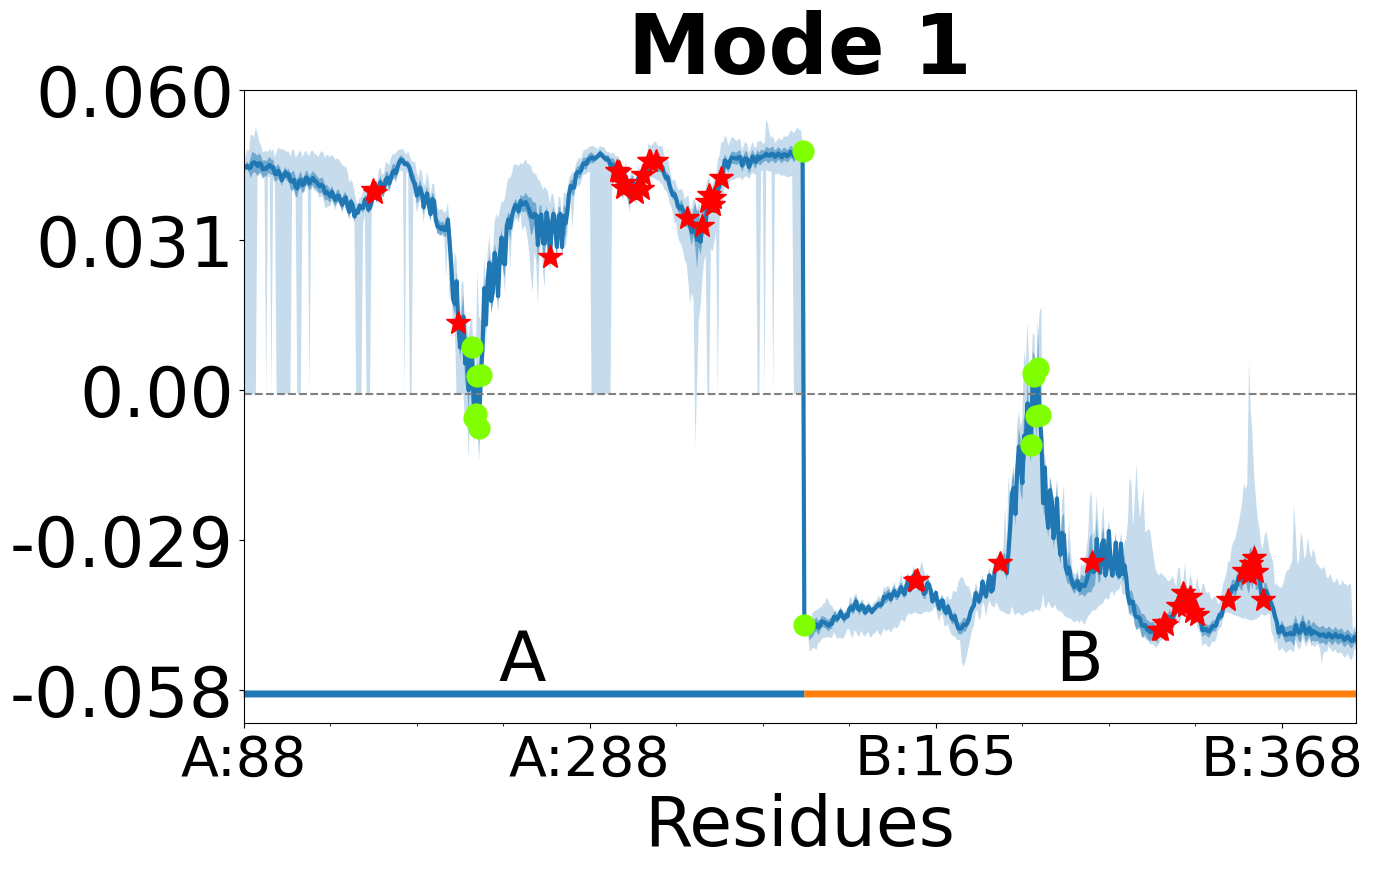

In [118]:
modes = 0 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [388, 389, 396, 141, 142, 397, 294, 295, 550, 551, 304, 305, 438, 439, 65, 66, 73, 74, 464, 465, 230, 231, 615, 616, 617, 614, 623, 624, 115, 116]
local loop motion []
current bindings are [75, 76, 124, 177, 216, 217, 219, 220, 227, 230, 231, 234, 235, 238, 256, 265, 268, 269, 271, 272, 276, 388, 389, 437, 490, 529, 530, 532, 533, 540, 543, 544, 547, 548, 551, 569, 578, 581, 582, 584, 585, 589]
current hits are [230, 231, 388, 389, 551]
# of overlaps finding from current mode is 5


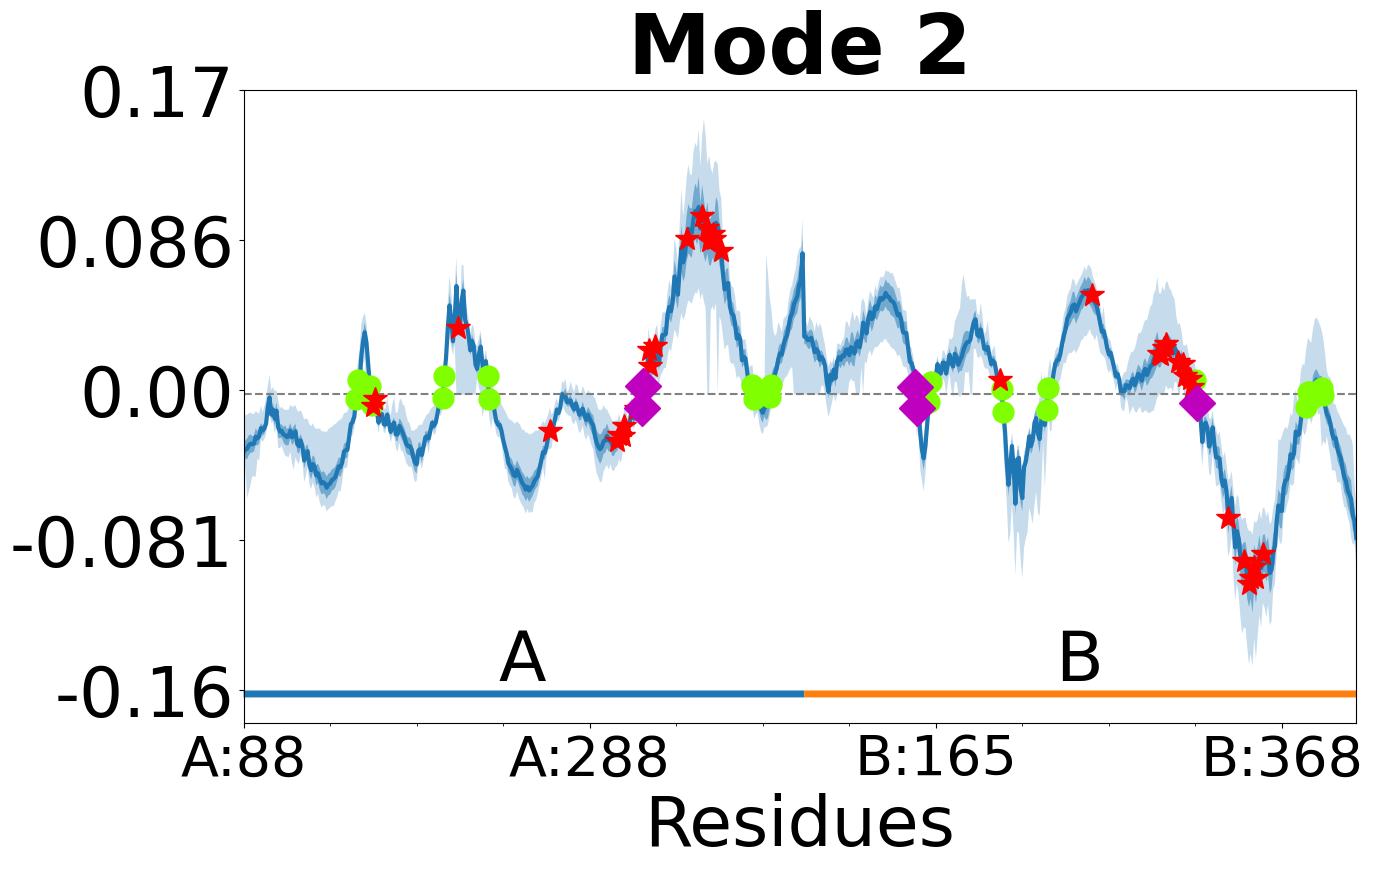

In [119]:
modes = 1 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [388, 133, 134, 135, 136, 389, 396, 141, 142, 397, 294, 295, 550, 551, 304, 305, 438, 439, 65, 66, 323, 324, 456, 73, 74, 458, 460, 461, 462, 457, 464, 465, 230, 231, 614, 615, 624, 625, 115, 116]
local loop motion []
current bindings are [75, 76, 124, 177, 216, 217, 219, 220, 227, 230, 231, 234, 235, 238, 256, 265, 268, 269, 271, 272, 276, 388, 389, 437, 490, 529, 530, 532, 533, 540, 543, 544, 547, 548, 551, 569, 578, 581, 582, 584, 585, 589]
current hits are [230, 231, 388, 389, 551]
# of overlaps finding from current mode is 5


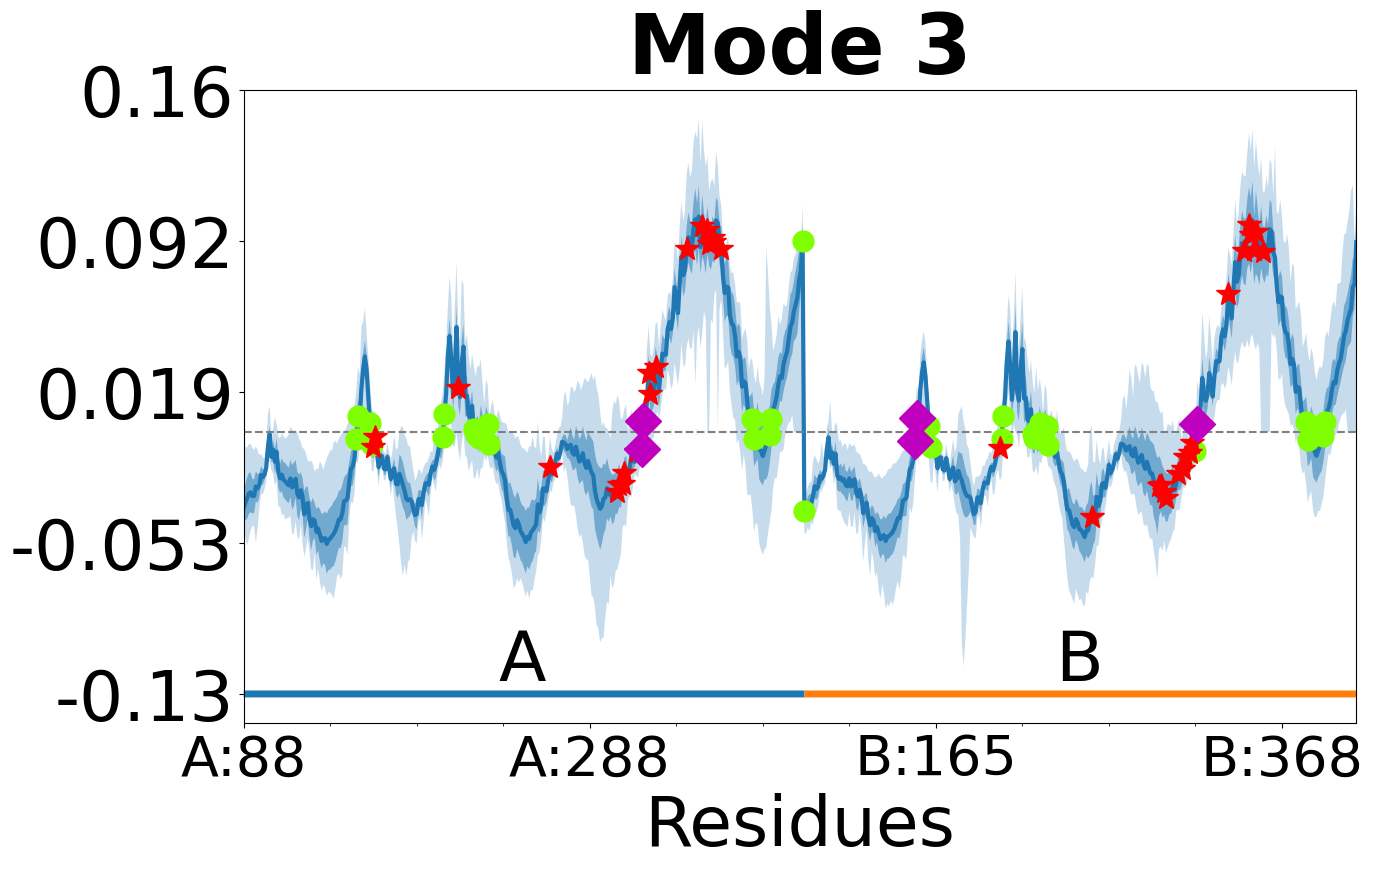

In [120]:
modes = 2 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

In [429]:
ORA(len(binding), 341, 56, 4)

0.5410738796757333

# Write Modes

In [34]:
len(averageEigVects[:, 0])

342

In [55]:
mode = 2
writePDB('./structure_demo/MAPK14_mode' + str(mode) + '.pdb', calphas, beta=eigenVects[:, mode])

'./structure_demo/MAPK14_mode2.pdb'

In [56]:
residue = []
new_b_factor = []
chain = 'A'

resiIndex = 0
for item in eigenVects[:, mode]:
    resiIndex += 1
    residue.append(resiIndex)
    new_b_factor.append(item)


In [57]:
with open('./structure_demo/DHFR_b_mode' + str(mode + 1) + '.txt', 'w') as wf:
    for i in range(len(residue)):
        wf.write(chain + ', ' + str(residue[i]) + ', ' + str(new_b_factor[i]) + '\n')
    

In [38]:
!pwd

/data/frank/Desktop/Hinges_Figures_all/MAPK14


# Monomer

In [10]:
currPDB = '2h42'
eachChain = 'A'
averageEigVals, averageEigVects, ids, gnms, averageEigVects = getModes(currPDB, eachChain, length=0.8, rmsd=2, Z=10)


@> Submitted Dali search for PDB "2h42A".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//2h42A/
@> Dali results were fetched in 0.3s.   
@> Obtained 2130 PDB chains from Dali for 2h42A.
@> 426 PDBs have been filtered out from 2130 Dali hits (remaining: 1704).
@> Retrieving 2h42A... [  0%]

RMSD less than  2.0 1.6503392 0.17819543
RMSD greater than 1A  1.9524654 0.67300755
# of similar structures is found from Dali 1704


@> 1704 PDBs were parsed in 490.78s.
@> Mapping 8ufiB_ca to the reference... [  3%] 39s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugbB_ca to the reference... [  3%] 39s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ufiA_ca to the reference... [  3%] 39s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugsA_ca to the reference... [  3%] 39s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ugsB_ca to the reference... [  3%] 39s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 4htzB_ca to the reference... [ 14%] 36s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 8ulgB_ca to the reference... [ 14%] 36s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 6mzbA_ca to the reference... [ 66%] 17s@> WARNING no atommaps w

@> WARNING last 36 modes for 274 modes from MaskedGNM 2h40A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 22 modes for 274 modes from MaskedGNM 3shzA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 23 modes for 274 modes from MaskedGNM 3shyA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 11 modes for 274 modes from MaskedGNM 7farA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 13 modes for 274 modes from MaskedGNM 4oewA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 10 modes for 274 modes from MaskedGNM 7faqA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 8w4tA_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 29 modes for 274 modes from MaskedGNM 4lm0A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 28 modes for 274 modes from MaskedGNM 2ouqA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 29 modes for 274 modes from MaskedGNM 2ouyA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 29 modes for 274 modes from MaskedGNM 4lkqA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 28 modes for 274 modes from MaskedGNM 6mscB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 29 modes for 274 modes from MaskedGNM 6msaA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 25 modes for 274 modes from MaskedGNM 5b4lA_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 28 modes for 274 modes from MaskedGNM 4ajgD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 28 modes for 274 modes from MaskedGNM 4aelB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 27 modes for 274 modes from MaskedGNM 4ys7B_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 29 modes for 274 modes from MaskedGNM 6ko0B_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 29 modes for 274 modes from MaskedGNM 2weyA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 28 modes for 274 modes from MaskedGNM 3ws9A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 25 modes for 274 modes from MaskedGNM 5b4kB_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 33 modes for 274 modes from MaskedGNM 4jibB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 23 modes for 274 modes from MaskedGNM 5dh5A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 29 modes for 274 modes from MaskedGNM 4wn1A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 34 modes for 274 modes from MaskedGNM 5xkmB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 34 modes for 274 modes from MaskedGNM 5tzcC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 35 modes for 274 modes from MaskedGNM 6c7jA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 36 modes for 274 modes from MaskedGNM 6ezfA_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 19 modes for 274 modes from MaskedGNM 5sfaB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5skuB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5edeB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sgnB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5c29A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 29 modes for 274 modes from MaskedGNM 5tz3C_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sklB_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 20 modes for 274 modes from MaskedGNM 5sjiC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sfzB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5skeB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sf4B_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sfrB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sjoB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sfoC_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 19 modes for 274 modes from MaskedGNM 5siuB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 21 modes for 274 modes from MaskedGNM 5sjhC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sf7B_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5seoB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5skkB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5skgB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sjxB_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 20 modes for 274 modes from MaskedGNM 5shsA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sj2C_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sfcB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sggC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sj3C_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5shrC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sfzC_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 20 modes for 274 modes from MaskedGNM 5sjqC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sh6C_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5si3B_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5shaB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sj7B_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sg9C_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sh1C_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 20 modes for 274 modes from MaskedGNM 5sj0A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5semC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 29 modes for 274 modes from MaskedGNM 5vp0A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5seaB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sebB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sj8C_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 33 modes for 274 modes from MaskedGNM 5u7lC_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 19 modes for 274 modes from MaskedGNM 5sjmB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sf6C_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5skiB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5skhC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5se9B_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5si0B_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5skiC_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 19 modes for 274 modes from MaskedGNM 5sidC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5si0A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5skrC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sggA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sh1A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sgwA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sj8D_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 20 modes for 274 modes from MaskedGNM 5sjyC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sk4B_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sf3A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sjiA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5siqA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5skcA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5sf7D_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 20 modes for 274 modes from MaskedGNM 5sg2A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5senC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sfdC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sjdC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sfkA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sg5C_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sioC_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 20 modes for 274 modes from MaskedGNM 5sgcC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5siwA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sj6C_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5shdC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sgfC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sg5A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5skrA_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 20 modes for 274 modes from MaskedGNM 5shlA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sijC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sk7D_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sg7B_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sh7A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sh8D_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sk3C_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 19 modes for 274 modes from MaskedGNM 5sibC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5skjA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sg8A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sjjA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sfhA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sfvC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sfeA_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 16 modes for 274 modes from MaskedGNM 3qpnA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sk3A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sf9C_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5sdxD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sjzA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 16 modes for 274 modes from MaskedGNM 3qppA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sjlC_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 19 modes for 274 modes from MaskedGNM 5sk0D_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5sknD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5skcD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5skoA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sfhC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5sfnD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sjfA_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 18 modes for 274 modes from MaskedGNM 5semD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5si3D_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5siuD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5sj7D_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5sgkD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sejA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sdwC_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 18 modes for 274 modes from MaskedGNM 5shaD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5shyA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5si1A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 5shpC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5sg2D_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5sf1D_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5sekD_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 18 modes for 274 modes from MaskedGNM 5sjrD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5sioD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 29 modes for 274 modes from MaskedGNM 4lm0B_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5sjfD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5sjdD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5skjD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 29 modes for 274 modes from MaskedGNM 4lm3B_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 22 modes for 274 modes from MaskedGNM 5tzxD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 5sg1B_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 17 modes for 274 modes from MaskedGNM 3uuoA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 24 modes for 274 modes from MaskedGNM 6c7fC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 22 modes for 274 modes from MaskedGNM 3k3hB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 22 modes for 274 modes from MaskedGNM 5tzxC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 23 modes for 274 modes from MaskedGNM 2hd1B_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 22 modes for 274 modes from MaskedGNM 3dylB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 21 modes for 274 modes from MaskedGNM 4htxC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 22 modes for 274 modes from MaskedGNM 4g2jA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 22 modes for 274 modes from MaskedGNM 4d08C_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 22 modes for 274 modes from MaskedGNM 3dy8A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 22 modes for 274 modes from MaskedGNM 4htxD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 22 modes for 274 modes from MaskedGNM 4y86B_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 19 modes for 274 modes from MaskedGNM 3v9bB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 17 modes for 274 modes from MaskedGNM 7xabB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 17 modes for 274 modes from MaskedGNM 3o0jA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 3v9bD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 17 modes for 274 modes from MaskedGNM 7yqfB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 23 modes for 274 modes from MaskedGNM 6ezuA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 8k4cB_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 16 modes for 274 modes from MaskedGNM 7xbbB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 6lrmA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 1xoqA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 7abeB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 6ft0B_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5k1iA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 17 modes for 274 modes from MaskedGNM 3sl5C_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 18 modes for 274 modes from MaskedGNM 1tbbA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 19 modes for 274 modes from MaskedGNM 6kjzB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 1y2cB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 6rcwD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 20 modes for 274 modes from MaskedGNM 6fg5B_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 7abjD_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 6imrA_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 18 modes for 274 modes from MaskedGNM 6fetA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 6bojC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 5wqaB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 7aagA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 6njhC_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 6fe7A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 18 modes for 274 modes from MaskedGNM 2pw3B_ca reduced has been discarded because at least one conformation has only 274 modes

@> WARNING last 16 modes for 274 modes from MaskedGNM 1xmyB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 15 modes for 274 modes from MaskedGNM 3iakA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 17 modes for 274 modes from MaskedGNM 1y2hB_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 16 modes for 274 modes from MaskedGNM 3iadA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 28 modes for 274 modes from MaskedGNM 7eg0A_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 22 modes for 274 modes from MaskedGNM 8sycA_ca reduced has been discarded because at least one conformation has only 274 modes
@> WARNING last 21 modes for 274 modes from MaskedGNM 8sycD_ca reduced has been discarded because at least one conformation has only 274 modes

In [11]:
currNumModes = getModesGivenThreshold(averageEigVals, 0.33)
currNumModes

4

In [12]:
bindings = ['75', '76', '124', '177', '216', '217', '219', '220', '227', '230', '231', '234', '235', '238', '256', '265', '268', '269', '271', '272', '276']
# bindings = ['75', '76', '124', '177', '216', '217', '219', '220', '227', '230', '231', '234', '235', '238', '256', '265', '268', '269', '272', '276', '388', '389', '437', '490', '529', '530', '532', '533', '540', '543', '544', '547', '548', '551', '569', '578', '581', '582', '585', '589']

binding = [int(x) for x in bindings]

In [13]:
Hinges_2 = getHinges2(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges2(averageEigVects, 3, 20)

Hinges_4 = getHinges2(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges2(averageEigVects, 3, 15)

In [14]:
protein_length = 326

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 21
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 121 10 0.21125126697659102
# of hinge sites for first 3 modes, overlap, hyper score 112 8 0.4377614473231686
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 131 10 0.3095156480008622
# of hinge sites for first 3 modes, overlap, hyper score 122 8 0.5594947443752736


In [15]:
glucor = parsePDB('2h42', subset='calpha')
calphas = glucor.select('calpha and chain A')
gnm = GNM('glu')
gnm.buildKirchhoff(calphas)
gnm.calcModes(n_modes=None)
Hinge0 = calcHinges(gnm[0])
Hinge1 = calcHinges(gnm[1])
Hinge2 = calcHinges(gnm[2])
Hinge3 = calcHinges(gnm[3])

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 2h42 downloaded (2h42.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 960 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Secondary structures were assigned to 758 residues.
@> Kirchhoff was built in 0.01s.
@> 325 modes were calculated in 0.04s.


In [16]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0 + Hinge1 + Hinge2 + Hinge3))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0 + Hinge1 + Hinge2 + Hinge3))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)


# of binding sites is 21
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 164 10 0.6841000577261555
# of hinge sites for 3 modes, overlap, hyper score 145 8 0.7973316435385642
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 171 10 0.7532977320667622
# of hinge sites for 3 modes, overlap, hyper score 154 8 0.8632224564831237


In [17]:
Hinges_2 = getHinges3(averageEigVects, currNumModes, [Hinge0, Hinge1, Hinge2, Hinge3], 20)
Hinges_3 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 20)

Hinges_4 = getHinges3(averageEigVects, currNumModes, [Hinge0, Hinge1, Hinge2, Hinge3], 15)
Hinges_5 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 15)

[22, 23]
[215, 216]
[317, 318]
[66, 67]
[22, 23]
[215, 216]
[317, 318]
[22, 23]
[215, 216]
[317, 318]
[66, 67]
[22, 23]
[215, 216]
[317, 318]


In [18]:
protein_length = 326

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)

# of binding sites is 21
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 95 5 0.7857188588443191
# of hinge sites for first 3 modes, overlap, hyper score 81 3 0.9299068397517678
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 98 6 0.6456459361221311
# of hinge sites for first 3 modes, overlap, hyper score 83 4 0.8297589805739973
